In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import time

from tqdm.auto import tqdm

from collections import OrderedDict

import jax.numpy as jnp
from jax import value_and_grad, grad, jit, vmap, partial
from jax import random, ops, lax

import context 


from examples.bayesian_NN.NN_data import X_train, X_test, y_train, y_test
from examples.bayesian_NN.NN_model import init_network, predict, accuracy, log_post, grad_log_post, batch_loglik
from examples.bayesian_NN.sampler import sgld_NN, kernel_NN
from examples.bayesian_NN.util import flatten_NN_params, load_NN_MAP, flatten_NN_params_jaxscan
from examples.bayesian_NN.sampler import sgld_NN_time_budget, sgld_NN_time_budget_CV, scan_NN

from examples.bayesian_NN.svrg import sgld_NN_time_budget_svrg
from examples.bayesian_NN.sghmc import sghmc_NN_time_budget
from examples.bayesian_NN.adam_sgld import sgld_adam_NN_time_budget

from successive_halving.sh import Base_SGLD_SuccHalv_Time, run_SH_time_budget_keep_3, create_T_list_2params, create_T_list_svrg
from ksd import imq_KSD
from util import wait_until_computed


from examples.bayesian_NN.NN_model import _ood_testing
from examples.bayesian_NN.NN_data import X_train_notMNIST, X_test_notMNIST, y_train_notMNIST, y_test_notMNIST
from examples.bayesian_NN.NN_model import get_ECE_MCE

/Users/jeremiecoullon/Documents/research/papers/SGMCMC_bandit_tuning/venv/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Uncertainty metrics for NN

Results:

### SGLD:

ECE:

- SH-ECE: 0.0107
- SH-KSD: 0.0173
- default: 0.0220
- adam: 0.0173


MCE:

- SH-ECE: 0.2697
- SH-KSD: 0.2522
- default: 0.2614
- adam: 0.1315


### SVRG



ECE:

- SH-ECE: 0.0131
- SH-KSD: 0.0151
- default: 0.0350

MCE:

- SH-ECE: 0.2471
- SH-KSD: 0.1965
- default: 0.3756

### SGHMC

ECE:

- SH-ECE: 0.0138
- SH-KSD: 0.0129
- default: 0.1008

MCE:

- SH-ECE: 0.3118
- SH-KSD: 0.2314
- default: 0.3485

In [26]:


def get_accuracy_list_NN(samples, thin_step):
    list_acc = []

    for sam in tqdm(samples[::thin_step]):
        list_acc.append(accuracy(sam, X_test, y_test))
        
    return list_acc

# sgld


In [3]:
key = random.PRNGKey(109)
x_0 = load_NN_MAP()
# time_budget = 200

time_budget = 400

In [3]:
# SH-ECE
log_dt, b_s_r = -5.032, 0.0011


dt = 10**(log_dt)
batch_size = int(X_train.shape[0]*b_s_r)
samples_SH_ECE, _ = sgld_NN_time_budget(key, time_budget, grad_log_post, 
                        dt, batch_size, x_0, X_train, y_train, save_rate=10)

In [4]:
# SH-KSD
log_dt, b_s_r = -5.48, 0.0050


dt = 10**(log_dt)
batch_size = int(X_train.shape[0]*b_s_r)
samples_test_SH_KSD, _ = sgld_NN_time_budget(key, time_budget, grad_log_post, 
                        dt, batch_size, x_0, X_train, y_train, save_rate=10)

In [5]:
# gridsearch
log_dt, b_s_r = -3.5, 0.1


dt = 10**(log_dt)
batch_size = int(X_train.shape[0]*b_s_r)
samples_test_default, _ = sgld_NN_time_budget(key, time_budget, grad_log_post, 
                        dt, batch_size, x_0, X_train, y_train, save_rate=10)

In [4]:
# adam

key = random.PRNGKey(0)
dt = 1e-5
batch_size = int(0.1*X_train.shape[0])
params_IC = load_NN_MAP()

samples_sgldadam, _ = sgld_adam_NN_time_budget(key, time_budget, dt, batch_size, 
                                      X_train, y_train, params_IC, save_rate=10)

print(f"Number of samples: {len(samples_sgldadam):,}")

Compiling
Running
Iteration 2000. Time: 49 / 400 sec
Iteration 4000. Time: 105 / 400 sec
Iteration 6000. Time: 159 / 400 sec
Iteration 8000. Time: 211 / 400 sec
Iteration 10000. Time: 257 / 400 sec
Iteration 12000. Time: 306 / 400 sec
Iteration 14000. Time: 353 / 400 sec
Iteration 16000. Time: 397 / 400 sec
Number of samples: 1,614


In [ ]:
print(len(samples_SH_ECE))

print(len(samples_test_SH_KSD))

print(len(samples_test_default))

print(len(samples_sgldadam))


In [119]:
thin_step = 10

thin_samples_sgld_SH_ECE = samples_SH_ECE[::thin_step]
thin_samples_sgld_SH_KSD = samples_test_SH_KSD[::thin_step]
thin_samples_sgld_default = samples_test_default[::thin_step]
thin_samples_sgld_adam = samples_sgldadam[::thin_step]

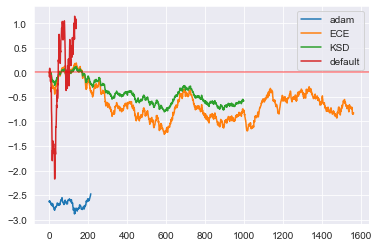

In [158]:
idx = 3

plt.plot(flatten_NN_params(thin_samples_sgld_adam)[:,idx], label="adam")
plt.plot(flat_samples_SH_ECE[:,idx], label="ECE")
plt.plot(flat_samples_SH_KSD[:,idx], label="KSD")
plt.plot(flat_samples_default[:,idx], label="default")
plt.axhline(flatten_NN_params([load_NN_MAP()])[0,idx], c='r', alpha=0.5)
plt.legend()

## Remove burn-in for each chain

In [178]:

# list_acc_sgld_SH_ECE = get_accuracy_list_NN(thin_samples_sgld_SH_ECE, 1)

# np.savetxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_SH_ECE.txt", list_acc_SH_ECE)

list_acc_sgld_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_SH_ECE.txt")

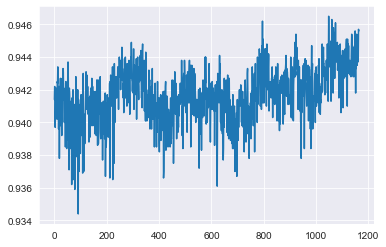

In [179]:
burnin_sgld_ECE = 400

plt.plot(list_acc_sgld_SH_ECE[burnin_sgld_ECE:])

In [180]:

# list_acc_sgld_SH_KSD = get_accuracy_list_NN(thin_samples_sgld_SH_KSD, 1)

# np.savetxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_SH_KSD.txt", list_acc_sgld_SH_KSD)

list_acc_sgld_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_SH_KSD.txt")



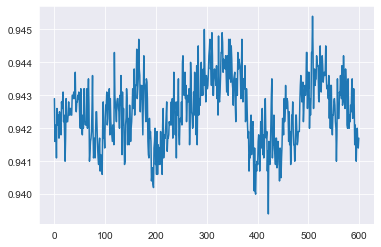

In [181]:
burnin_sgld_KSD = 400

plt.plot(list_acc_sgld_SH_KSD[burnin_sgld_KSD:])

In [182]:
# list_acc_sgld_default = get_accuracy_list_NN(thin_samples_sgld_default, 1)

# np.savetxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_default.txt", list_acc_sgld_default)

list_acc_sgld_default = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_default.txt")


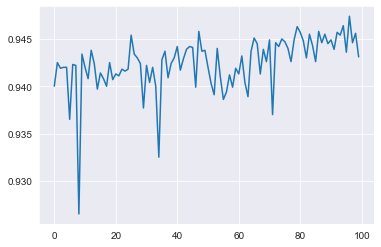

In [183]:
burnin_sgld_default = 40

plt.plot(list_acc_sgld_default[burnin_sgld_default:])

In [11]:

# list_acc_sgld_adam = get_accuracy_list_NN(thin_samples_sgld_adam, 1)

# np.savetxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_adam.txt", list_acc_sgld_adam)

list_acc_sgld_adam = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_adam.txt")



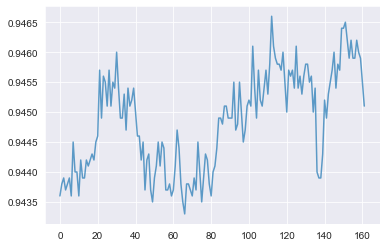

In [19]:
burnin_sgld_adam = 0

plt.plot(list_acc_sgld_adam[burnin_sgld_adam:], label="adam", alpha=0.7)

In [77]:
list_acc_sgld_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_SH_ECE.txt")
list_acc_sgld_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_SH_KSD.txt")
list_acc_sgld_default = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_default.txt")
list_acc_sgld_adam = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_adam.txt")

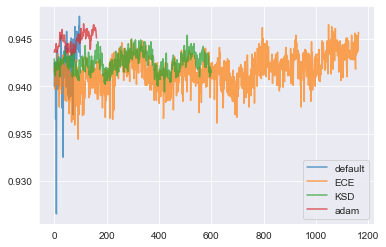

In [78]:
burnin_sgld_ECE = 400
burnin_sgld_KSD = 400
burnin_sgld_default = 40
burnin_sgld_adam = 0

plt.plot(list_acc_sgld_default[burnin_sgld_default:], label="default", alpha=0.7)

plt.plot(list_acc_sgld_SH_ECE[burnin_sgld_ECE:], label="ECE", alpha=0.7)

plt.plot(list_acc_sgld_SH_KSD[burnin_sgld_KSD:], label="KSD", alpha=0.7)

plt.plot(list_acc_sgld_adam[burnin_sgld_adam:], label="adam", alpha=0.7)

plt.legend()

### ECE and MCE

In [80]:


print("ECE..")
flat_samples_SH_ECE = flatten_NN_params(thin_samples_sgld_SH_ECE)

print("KSD..")
flat_samples_SH_KSD = flatten_NN_params(thin_samples_sgld_SH_KSD)

print("default..")
flat_samples_default = flatten_NN_params(thin_samples_sgld_default)

print("adam..")
flat_samples_adam = flatten_NN_params(thin_samples_sgld_adam)

print("Done.")

ECE..
KSD..
default..
Done.


In [78]:
print(burnin_sgld_default)
print(burnin_sgld_ECE)
print(burnin_sgld_KSD)
print(burnin_sgld_adam)

print(flat_samples_SH_ECE.shape)
print(flat_samples_SH_KSD.shape)
print(flat_samples_default.shape)
print(flat_samples_adam.shape)


40
400
400


In [92]:
print("ECE..")
ece_SH_ECE, mce_SH_ECE = get_ECE_MCE(flat_samples_SH_ECE[burnin_sgld_ECE:], X_test, y_test, M=10, pbar=True)

print("KSD..")
ece_SH_KSD, mce_SH_KSD = get_ECE_MCE(flat_samples_SH_KSD[burnin_sgld_KSD:], X_test, y_test, M=10, pbar=True)

print("default..")
ece_default, mce_default = get_ECE_MCE(flat_samples_default[burnin_sgld_default:], X_test, y_test, M=10, pbar=True)

print("adam..")
ece_adam, mce_adam = get_ECE_MCE(flat_samples_adam[burnin_sgld_adam:], X_test, y_test, M=10, pbar=True)


ECE..



KSD..



default..


In [28]:
# ece_array_sgld = np.array([ece_SH_ECE, ece_SH_KSD, ece_default, ece_adam])
# mce_array_sgld = np.array([mce_SH_ECE, mce_SH_KSD, mce_default, mce_adam])

# np.savetxt("outputs/NN_uncertainty_tests/sgld/ece_array_sgld.txt", ece_array_sgld)
# np.savetxt("outputs/NN_uncertainty_tests/sgld/mce_array_sgld.txt", mce_array_sgld)


ece_array_sgld = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/ece_array_sgld.txt")
mce_array_sgld = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/mce_array_sgld.txt")



In [31]:
ece_SH_ECE, ece_SH_KSD, ece_default, ece_adam = ece_array_sgld
mce_SH_ECE, mce_SH_KSD, mce_default, mce_adam = mce_array_sgld


print("ECE:\n")
print(f"SH-ECE: {ece_SH_ECE:.4f}")
print(f"SH-KSD: {ece_SH_KSD:.4f}")
print(f"default: {ece_default:.4f}")
print(f"adam: {ece_adam:.4f}")


print("\n\nMCE:\n")
print(f"SH-ECE: {mce_SH_ECE:.4f}")
print(f"SH-KSD: {mce_SH_KSD:.4f}")
print(f"default: {mce_default:.4f}")
print(f"adam: {mce_adam:.4f}")


ECE:

SH-ECE: 0.0107
SH-KSD: 0.0173
default: 0.0220
adam: 0.0173


MCE:

SH-ECE: 0.2697
SH-KSD: 0.2522
default: 0.2614
adam: 0.1315


### OOD testing

In [99]:
print("Calculating for SH-ECE...")
ood_samples_SH_ECE = _ood_testing(flat_samples_SH_ECE, X_test_notMNIST[::2])

wait_until_computed(ood_samples_SH_ECE)

print("Calculating for SH-KSD...")
ood_samples_SH_KSD = _ood_testing(flat_samples_SH_KSD, X_test_notMNIST[::2])

wait_until_computed(ood_samples_SH_KSD)

print("Calculating for default..")

ood_samples_default = _ood_testing(flat_samples_default, X_test_notMNIST[::2])

wait_until_computed(ood_samples_default)

print("Calculating for adam..")

ood_samples_adam = _ood_testing(flat_samples_adam, X_test_notMNIST[::2])

wait_until_computed(ood_samples_adam)


print("Done.")

Calculating for SH-ECE...
Calculating for SH-KSD...
Calcluating for default..
Done.


In [106]:
sorted_ood_sgld_SH_ECE = sorted(ood_samples_SH_ECE)
sorted_ood_sgld_SH_KSD = sorted(ood_samples_SH_KSD)
sorted_ood_sgld_default = sorted(ood_samples_default)
sorted_ood_sgld_adam = sorted(ood_samples_adam)


In [35]:
# np.savetxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_SH_ECE.txt", sorted_ood_sgld_SH_ECE)
# np.savetxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_SH_KSD.txt", sorted_ood_sgld_SH_KSD)
# np.savetxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_defaultsgld.txt", sorted_ood_sgld_default)
# np.savetxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_sgld_adam.txt", sorted_ood_sgld_adam)


sorted_ood_sgld_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_SH_ECE.txt")
sorted_ood_sgld_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_SH_KSD.txt")
sorted_ood_sgld_default = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_defaultsgld.txt")
sorted_ood_sgld_adam = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_sgld_adam.txt")

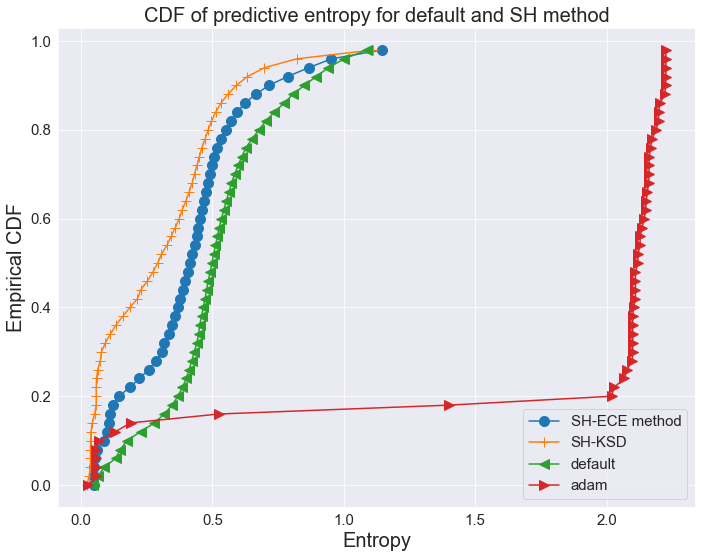

In [38]:
thin_step = 100

plt.rcParams.update({'font.size':15})
y_range = np.linspace(0, 1, (len(sorted_ood_sgld_SH_ECE)))[::thin_step]
plt.figure(figsize=(10,8))


plt.plot(sorted_ood_sgld_SH_ECE[::thin_step], y_range, 
         label=r"SH-ECE method", marker="o", markersize=10)


plt.plot(sorted_ood_sgld_SH_KSD[::thin_step], y_range, 
         label=r"SH-KSD", marker="+", markersize=10)

plt.plot(sorted_ood_sgld_default[::thin_step], y_range, 
         label=r"default", marker="<", markersize=10)

plt.plot(sorted_ood_sgld_adam[::thin_step], y_range, 
         label=r"adam", marker=">", markersize=10)


plt.title("CDF of predictive entropy for default and SH method", size=20)
plt.tight_layout()
plt.legend()
plt.xlabel("Entropy", size=20)
plt.ylabel("Empirical CDF", size=20)
plt.tight_layout()

# plt.savefig("images/NN_uncertainty_metrics/sgld_OOD.png")

# SVRG

In [17]:
# SH-ECE

log_dt, b_s_r =  -4.73, 0.0038

time_budget = 400


key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
dt = 10**(log_dt)
update_rate = 1000
batch_size = int(b_s_r*X_train.shape[0])
samples_svrg_SH_ECE = sgld_NN_time_budget_svrg(key, time_budget, dt, batch_size, 
                               MAP_params, update_rate, save_rate=10)

In [24]:
# SH-KSD

log_dt, b_s_r = -5.19, 0.011

key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
dt = 10**(log_dt)
update_rate = 1000
batch_size = int(b_s_r*X_train.shape[0])
samples_svrg_SH_KSD = sgld_NN_time_budget_svrg(key, time_budget, dt, batch_size, 
                               MAP_params, update_rate, save_rate=10)

In [25]:
# default


log_dt, b_s_r= -3.25, 0.1

key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
dt = 10**(log_dt)
update_rate = 1000
batch_size = int(b_s_r*X_train.shape[0])
samples_svrg_default = sgld_NN_time_budget_svrg(key, time_budget, dt, batch_size, 
                               MAP_params, update_rate, save_rate=10)

In [18]:
print(len(samples_svrg_SH_ECE))
# print(len(samples_svrg_SH_KSD))
# print(len(samples_svrg_default))


6967


In [27]:
thin_step = 4

thin_samples_svrg_SH_ECE = samples_svrg_SH_ECE[::thin_step]
thin_samples_svrg_SH_KSD = samples_svrg_SH_KSD[::thin_step]
thin_samples_svrg_default = samples_svrg_default[::thin_step]


In [28]:
list_acc_svrg_SH_ECE = get_accuracy_list_NN(thin_samples_svrg_SH_ECE, 1)
list_acc_svrg_SH_KSD = get_accuracy_list_NN(thin_samples_svrg_SH_KSD, 1)
list_acc_svrg_default = get_accuracy_list_NN(thin_samples_svrg_default, 1)



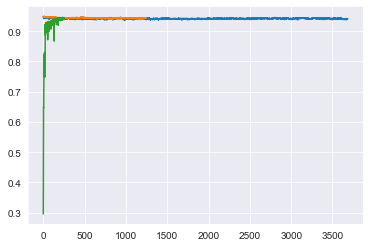

In [29]:
plt.plot(list_acc_svrg_SH_ECE)
plt.plot(list_acc_svrg_SH_KSD)
plt.plot(list_acc_svrg_default)

In [54]:
# np.savetxt("outputs/NN_uncertainty_tests/svrg/accuracy_lists/list_acc_svrg_SH_ECE.txt", list_acc_svrg_SH_ECE)
# np.savetxt("outputs/NN_uncertainty_tests/svrg/accuracy_lists/list_acc_svrg_SH_KSD.txt", list_acc_svrg_SH_KSD)
# np.savetxt("outputs/NN_uncertainty_tests/svrg/accuracy_lists/list_acc_svrg_default.txt", list_acc_svrg_default)

list_acc_svrg_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/accuracy_lists/list_acc_svrg_SH_ECE.txt")
list_acc_svrg_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/accuracy_lists/list_acc_svrg_SH_KSD.txt")
list_acc_svrg_default = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/accuracy_lists/list_acc_svrg_default.txt")



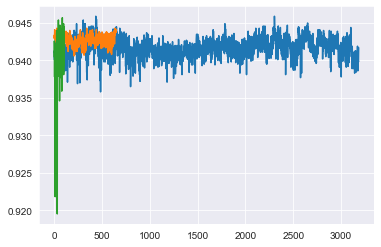

In [43]:
burnin_svrg_SH_ECE = 500
burnin_svrg_SH_KSD = 600
burnin_svrg_default = 150

plt.plot(list_acc_svrg_SH_ECE[burnin_svrg_SH_ECE:])
plt.plot(list_acc_svrg_SH_KSD[burnin_svrg_SH_KSD:])
plt.plot(list_acc_svrg_default[burnin_svrg_default:])

In [96]:
flat_samples_svrg_SH_ECE = flatten_NN_params(thin_samples_svrg_SH_ECE[burnin_svrg_SH_ECE:])

In [97]:
ece_svrg_SH_ECE, mce_svrg_SH_ECE = get_ECE_MCE(flat_samples_svrg_SH_ECE, X_test[::2], y_test[::2], M=10, pbar=True)

ece_svrg_SH_ECE, mce_svrg_SH_ECE

(0.013123585510253907, DeviceArray(0.2470808, dtype=float32))

In [ ]:

flat_samples_svrg_SH_ECE = flatten_NN_params(thin_samples_svrg_SH_ECE[burnin_svrg_SH_ECE:])
flat_samples_svrg_SH_KSD = flatten_NN_params(thin_samples_svrg_SH_KSD[burnin_svrg_SH_KSD:])
flat_samples_svrg_default = flatten_NN_params(thin_samples_svrg_default[burnin_svrg_default:])


In [47]:
print(flat_samples_svrg_SH_ECE.shape)
print(flat_samples_svrg_SH_KSD.shape)

print(flat_samples_svrg_default.shape)


(1641, 79510)
(645, 79510)
(104, 79510)


In [48]:
ece_svrg_SH_ECE, mce_svrg_SH_ECE = get_ECE_MCE(flat_samples_svrg_SH_ECE, X_test[::2], y_test[::2], M=10, pbar=True)
ece_svrg_SH_KSD, mce_svrg_SH_KSD = get_ECE_MCE(flat_samples_svrg_SH_KSD, X_test[::2], y_test[::2], M=10, pbar=True)
ece_svrg_default, mce_svrg_default = get_ECE_MCE(flat_samples_svrg_default, X_test[::2], y_test[::2], M=10, pbar=True)

ece_array_svrg = np.array([ece_svrg_SH_ECE, ece_svrg_SH_KSD, ece_svrg_default])
mce_array_svrg = np.array([mce_svrg_SH_ECE, mce_svrg_SH_KSD, mce_svrg_default])

In [103]:
np.savetxt("outputs/NN_uncertainty_tests/svrg/ece_array_svrg.txt", ece_array_svrg)
np.savetxt("outputs/NN_uncertainty_tests/svrg/mce_array_svrg.txt", mce_array_svrg)


ece_array_svrg = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/ece_array_svrg.txt")
mce_array_svrg = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/mce_array_svrg.txt")

ece_svrg_SH_ECE, ece_svrg_SH_KSD, ece_svrg_default = ece_array_svrg
mce_svrg_SH_ECE, mce_svrg_SH_KSD, mce_svrg_default = mce_array_svrg


In [104]:
print("ECE:\n")
print(f"SH-ECE: {ece_svrg_SH_ECE:.4f}")
print(f"SH-KSD: {ece_svrg_SH_KSD:.4f}")
print(f"default: {ece_svrg_default:.4f}")


print("MCE:\n")
print(f"SH-ECE: {mce_svrg_SH_ECE:.4f}")
print(f"SH-KSD: {mce_svrg_SH_KSD:.4f}")
print(f"default: {mce_svrg_default:.4f}")

ECE:

SH-ECE: 0.0131
SH-KSD: 0.0151
default: 0.0350
MCE:

SH-ECE: 0.2471
SH-KSD: 0.1965
default: 0.3756


### OOD testing

In [55]:


print("SH - ECE...")
ood_samples_svrg_SH_ECE = _ood_testing(flat_samples_svrg_SH_ECE[::5], X_test_notMNIST[::5])

wait_until_computed(ood_samples_svrg_SH_ECE)

print("SH - KSD...")
ood_samples_svrg_SH_KSD = _ood_testing(flat_samples_svrg_SH_KSD[::5], X_test_notMNIST[::5])

wait_until_computed(ood_samples_svrg_SH_KSD)

print("Default..")

ood_samples_svrg_default = _ood_testing(flat_samples_svrg_default[::5], X_test_notMNIST[::5])

wait_until_computed(ood_samples_svrg_default)

sorted_ood_svrg_SH_ECE = sorted(ood_samples_svrg_SH_ECE)
sorted_ood_svrg_SH_KSD = sorted(ood_samples_svrg_SH_KSD)
sorted_ood_svrg_default = sorted(ood_samples_svrg_default)


print("Done.")

SH - ECE...
SH - KSD...
Default..
Done.


In [112]:
# np.savetxt("outputs/NN_uncertainty_tests/svrg/sorted_ood_svrg_SH_ECE.txt", sorted_ood_svrg_SH_ECE)

In [113]:
# np.savetxt("outputs/NN_uncertainty_tests/svrg/sorted_ood_svrg_SH_ECE.txt", sorted_ood_svrg_SH_ECE)
# np.savetxt("outputs/NN_uncertainty_tests/svrg/sorted_ood_svrg_SH_KSD.txt", sorted_ood_svrg_SH_KSD)
# np.savetxt("outputs/NN_uncertainty_tests/svrg/sorted_ood_svrg_default.txt", sorted_ood_svrg_default)


sorted_ood_svrg_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/sorted_ood_svrg_SH_ECE.txt")
sorted_ood_svrg_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/sorted_ood_svrg_SH_KSD.txt")
sorted_ood_svrg_default = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/sorted_ood_svrg_default.txt")


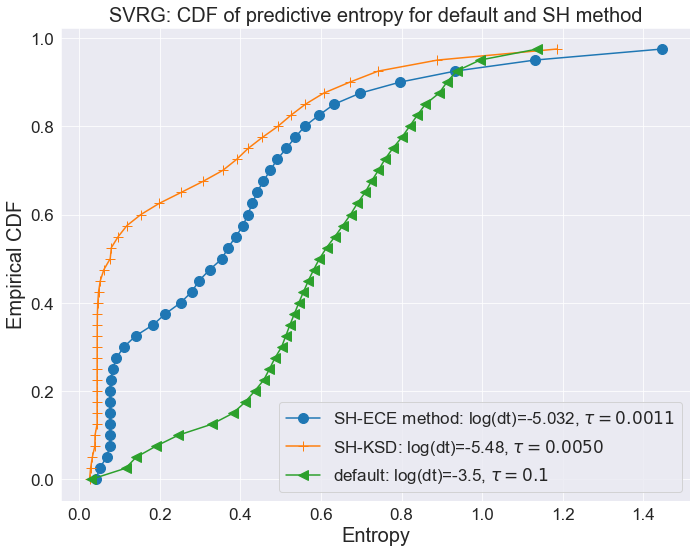

In [114]:
thin_step = 50

y_range = np.linspace(0, 1, (len(sorted_ood_svrg_SH_ECE)))[::thin_step]
plt.figure(figsize=(10,8))

plt.plot(sorted_ood_svrg_SH_ECE[::thin_step], y_range, 
         label=r"SH-ECE method: log(dt)=-5.032, $\tau=0.0011$", marker="o", markersize=10)


plt.plot(sorted_ood_svrg_SH_KSD[::thin_step], y_range, 
         label=r"SH-KSD: log(dt)=-5.48, $\tau=0.0050$", marker="+", markersize=10)

plt.plot(sorted_ood_svrg_default[::thin_step], y_range, 
         label=r"default: log(dt)=-3.5, $\tau=0.1$", marker="<", markersize=10)


plt.title("SVRG: CDF of predictive entropy for default and SH method", size=20)
plt.tight_layout()
plt.legend()
plt.xlabel("Entropy", size=20)
plt.ylabel("Empirical CDF", size=20)
plt.tight_layout()

# plt.savefig("images/NN_uncertainty_metrics/svrg_OOD.png")

# SGHMC

In [3]:
# SH-ECE

# time_budget = 200
time_budget = 500

log_dt, b_s_r, L =  -5.98, 0.028, 7

key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
dt = 10**(log_dt)
batch_size = int(b_s_r*X_train.shape[0])
samples_sghmc_SH_ECE = sghmc_NN_time_budget(key, time_budget, dt, batch_size, 
                                         MAP_params, L, save_rate=10)

In [21]:
# SH-KSD

log_dt, b_s_r, L = -5.59, 0.016, 3

key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
dt = 10**(log_dt)
batch_size = int(b_s_r*X_train.shape[0])
samples_sghmc_SH_KSD = sghmc_NN_time_budget(key, time_budget, dt, batch_size, 
                                         MAP_params, L, save_rate=10)

In [22]:
# default


log_dt, b_s_r, L = -5., 0.1, 26

key = random.PRNGKey(0)
MAP_params = load_NN_MAP()
dt = 10**(log_dt)
batch_size = int(b_s_r*X_train.shape[0])
samples_sghmc_default = sghmc_NN_time_budget(key, time_budget, dt, batch_size, 
                                         MAP_params, L, save_rate=10)

In [23]:
# print(len(samples_sghmc_SH_ECE))
print(len(samples_sghmc_SH_KSD))
print(len(samples_sghmc_default))

4080
109


In [24]:
thin_step = 1

thin_samples_sghmc_SH_ECE = samples_sghmc_SH_ECE[::thin_step]
thin_samples_sghmc_SH_KSD = samples_sghmc_SH_KSD[::thin_step]
thin_samples_sghmc_default = samples_sghmc_default[::thin_step]


In [25]:
list_acc_sghmc_SH_ECE = get_accuracy_list_NN(thin_samples_sghmc_SH_ECE, 1)
list_acc_sghmc_SH_KSD = get_accuracy_list_NN(thin_samples_sghmc_SH_KSD, 1)
list_acc_sghmc_default = get_accuracy_list_NN(thin_samples_sghmc_default, 1)



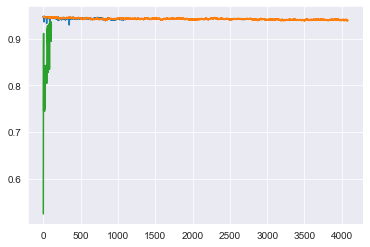

In [29]:
plt.plot(list_acc_sghmc_SH_ECE)
plt.plot(list_acc_sghmc_SH_KSD)
plt.plot(list_acc_sghmc_default)

In [28]:
# np.savetxt("outputs/NN_uncertainty_tests/sghmc/accuracy_lists/list_acc_sghmc_SH_ECE.txt", list_acc_sghmc_SH_ECE)
# np.savetxt("outputs/NN_uncertainty_tests/sghmc/accuracy_lists/list_acc_sghmc_SH_KSD.txt", list_acc_sghmc_SH_KSD)
# np.savetxt("outputs/NN_uncertainty_tests/sghmc/accuracy_lists/list_acc_sghmc_default.txt", list_acc_sghmc_default)

list_acc_sghmc_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/accuracy_lists/list_acc_sghmc_SH_ECE.txt")
list_acc_sghmc_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/accuracy_lists/list_acc_sghmc_SH_KSD.txt")
list_acc_sghmc_default = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/accuracy_lists/list_acc_sghmc_default.txt")



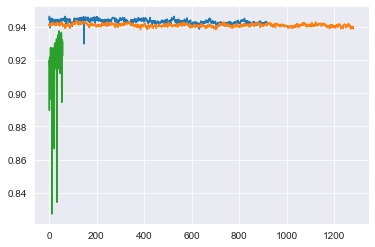

In [42]:
burnin_sghmc_SH_ECE = 200
burnin_sghmc_SH_KSD = 2800
burnin_sghmc_default = 50

plt.plot(list_acc_sghmc_SH_ECE[burnin_sghmc_SH_ECE:])
plt.plot(list_acc_sghmc_SH_KSD[burnin_sghmc_SH_KSD:])
plt.plot(list_acc_sghmc_default[burnin_sghmc_default:])

In [43]:



flat_samples_sghmc_SH_ECE = flatten_NN_params(thin_samples_sghmc_SH_ECE[burnin_sghmc_SH_ECE:])
flat_samples_sghmc_SH_KSD = flatten_NN_params(thin_samples_sghmc_SH_KSD[burnin_sghmc_SH_KSD:])
flat_samples_sghmc_default = flatten_NN_params(thin_samples_sghmc_default[burnin_sghmc_default:])


In [44]:
ece_sghmc_SH_ECE, mce_sghmc_SH_ECE = get_ECE_MCE(flat_samples_sghmc_SH_ECE, 
                                                 X_test[::2], y_test[::2], M=10, pbar=True)

ece_sghmc_SH_KSD, mce_sghmc_SH_KSD = get_ECE_MCE(flat_samples_sghmc_SH_KSD, 
                                                 X_test[::2], y_test[::2], M=10, pbar=True)

ece_sghmc_default, mce_sghmc_default = get_ECE_MCE(flat_samples_sghmc_default, 
                                                   X_test[::2], y_test[::2], M=10, pbar=True)



ece_array_sghmc = np.array([ece_sghmc_SH_ECE, ece_sghmc_SH_KSD, ece_sghmc_default])
mce_array_sghmc = np.array([mce_sghmc_SH_ECE, mce_sghmc_SH_KSD, mce_sghmc_default])


In [48]:


# np.savetxt("outputs/NN_uncertainty_tests/sghmc/ece_array_sghmc.txt", ece_array_sghmc)
# np.savetxt("outputs/NN_uncertainty_tests/sghmc/mce_array_sghmc.txt", mce_array_sghmc)


ece_array_sghmc = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/ece_array_sghmc.txt")
mce_array_sghmc = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/mce_array_sghmc.txt")


ece_sghmc_SH_ECE, ece_sghmc_SH_KSD, ece_sghmc_default = ece_array_sghmc
mce_sghmc_SH_ECE, mce_sghmc_SH_KSD, mce_sghmc_default = mce_array_sghmc


In [51]:
print("ECE:\n")
print(f"SH-ECE: {ece_sghmc_SH_ECE:.4f}")
print(f"SH-KSD: {ece_sghmc_SH_KSD:.4f}")
print(f"default: {ece_sghmc_default:.4f}")


print("\nMCE:\n")
print(f"SH-ECE: {mce_sghmc_SH_ECE:.4f}")
print(f"SH-KSD: {mce_sghmc_SH_KSD:.4f}")
print(f"default: {mce_sghmc_default:.4f}")

ECE:

SH-ECE: 0.0138
SH-KSD: 0.0129
default: 0.1008
MCE:

SH-ECE: 0.3118
SH-KSD: 0.2314
default: 0.3485


### OOD testing

In [52]:


print("SH - ECE...")
ood_samples_sghmc_SH_ECE = _ood_testing(flat_samples_sghmc_SH_ECE[::5], X_test_notMNIST[::5])

wait_until_computed(ood_samples_sghmc_SH_ECE)

print("SH - KSD...")
ood_samples_sghmc_SH_KSD = _ood_testing(flat_samples_sghmc_SH_KSD[::5], X_test_notMNIST[::5])

wait_until_computed(ood_samples_sghmc_SH_KSD)

print("Default..")

ood_samples_sghmc_default = _ood_testing(flat_samples_sghmc_default[::5], X_test_notMNIST[::5])

wait_until_computed(ood_samples_sghmc_default)

sorted_ood_sghmc_SH_ECE = sorted(ood_samples_sghmc_SH_ECE)
sorted_ood_sghmc_SH_KSD = sorted(ood_samples_sghmc_SH_KSD)
sorted_ood_sghmc_default = sorted(ood_samples_sghmc_default)


print("Done.")

SH - ECE...
SH - KSD...
Default..
Done.


In [53]:
# np.savetxt("outputs/NN_uncertainty_tests/sghmc/sorted_ood_sghmc_SH_ECE.txt", sorted_ood_sghmc_SH_ECE)
# np.savetxt("outputs/NN_uncertainty_tests/sghmc/sorted_ood_sghmc_SH_KSD.txt", sorted_ood_sghmc_SH_KSD)
# np.savetxt("outputs/NN_uncertainty_tests/sghmc/sorted_ood_sghmc_default.txt", sorted_ood_sghmc_default)


sorted_ood_sghmc_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/sorted_ood_sghmc_SH_ECE.txt")
sorted_ood_sghmc_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/sorted_ood_sghmc_SH_KSD.txt")
sorted_ood_sghmc_default = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/sorted_ood_sghmc_default.txt")


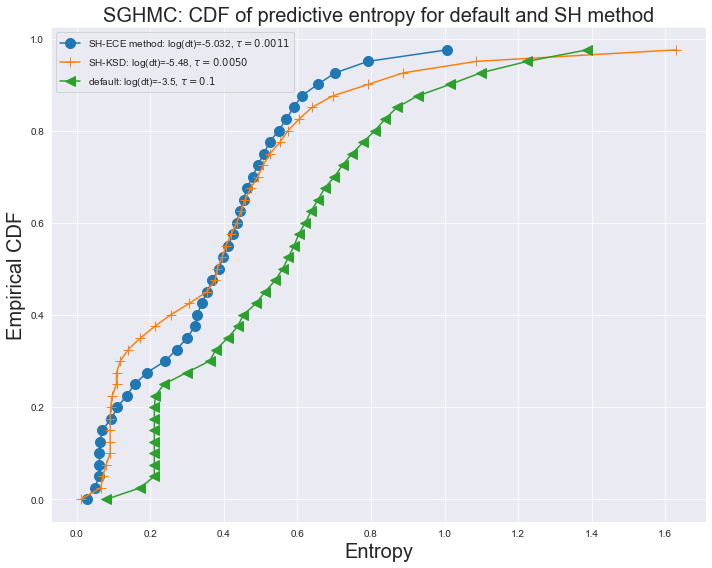

In [54]:
thin_step = 50

y_range = np.linspace(0, 1, (len(sorted_ood_sghmc_SH_ECE)))[::thin_step]
plt.figure(figsize=(10,8))

plt.plot(sorted_ood_sghmc_SH_ECE[::thin_step], y_range, 
         label=r"SH-ECE method: log(dt)=-5.032, $\tau=0.0011$", marker="o", markersize=10)


plt.plot(sorted_ood_sghmc_SH_KSD[::thin_step], y_range, 
         label=r"SH-KSD: log(dt)=-5.48, $\tau=0.0050$", marker="+", markersize=10)

plt.plot(sorted_ood_sghmc_default[::thin_step], y_range, 
         label=r"default: log(dt)=-3.5, $\tau=0.1$", marker="<", markersize=10)


plt.title("SGHMC: CDF of predictive entropy for default and SH method", size=20)
plt.tight_layout()
plt.legend()
plt.xlabel("Entropy", size=20)
plt.ylabel("Empirical CDF", size=20)
plt.tight_layout()

# plt.savefig("images/NN_uncertainty_metrics/sghmc_OOD.png")


# 3 OOD plots

In [2]:
# sgld
sorted_ood_sgld_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_SH_ECE.txt")
sorted_ood_sgld_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_SH_KSD.txt")
sorted_ood_sgld_default = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_defaultsgld.txt")
sorted_ood_sgld_adam = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/sorted_ood_sgld_adam.txt")


# svrg

sorted_ood_svrg_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/sorted_ood_svrg_SH_ECE.txt")
sorted_ood_svrg_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/sorted_ood_svrg_SH_KSD.txt")
sorted_ood_svrg_default = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/sorted_ood_svrg_default.txt")


# sghmc

sorted_ood_sghmc_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/sorted_ood_sghmc_SH_ECE.txt")
sorted_ood_sghmc_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/sorted_ood_sghmc_SH_KSD.txt")
sorted_ood_sghmc_default = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/sorted_ood_sghmc_default.txt")


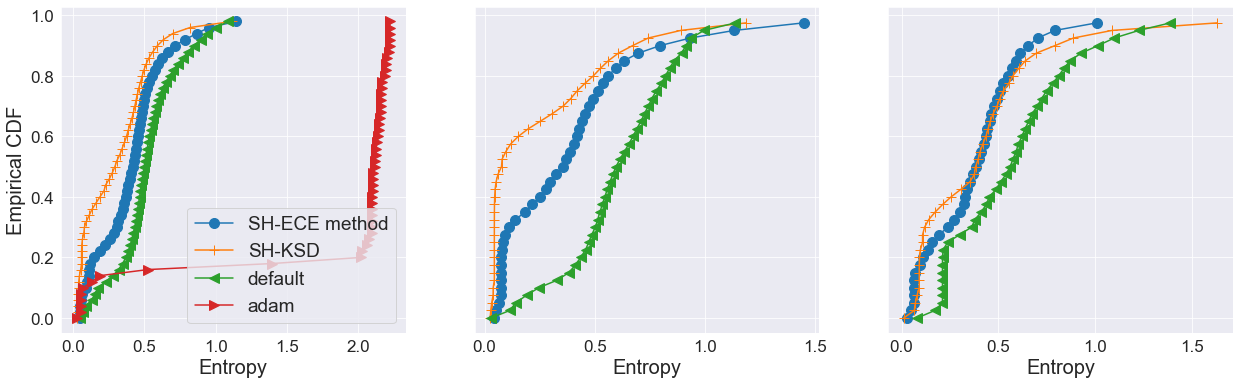

In [8]:
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(1,3, figsize=(21, 6), sharey=True)

# ===============
# SGLD
thin_step = 100
y_range = np.linspace(0, 1, (len(sorted_ood_sgld_SH_ECE)))[::thin_step]

ax[0].plot(sorted_ood_sgld_SH_ECE[::thin_step], y_range, 
         label=r"SH-ECE method", marker="o", markersize=10)


ax[0].plot(sorted_ood_sgld_SH_KSD[::thin_step], y_range, 
         label=r"SH-KSD", marker="+", markersize=10)

ax[0].plot(sorted_ood_sgld_default[::thin_step], y_range, 
         label=r"default", marker="<", markersize=10)

ax[0].plot(sorted_ood_sgld_adam[::thin_step], y_range, 
         label=r"adam", marker=">", markersize=10)


# ax[0].set_title("SGLD", size=20)
ax[0].set_xlabel("Entropy", size=20)
ax[0].set_ylabel("Empirical CDF", size=20)


# ===============
# # SVRG


thin_step = 50

y_range = np.linspace(0, 1, (len(sorted_ood_svrg_SH_ECE)))[::thin_step]

ax[1].plot(sorted_ood_svrg_SH_ECE[::thin_step], y_range, 
         label=r"SH-ECE method: log(dt)=-5.032, $\tau=0.0011$", marker="o", markersize=10)


ax[1].plot(sorted_ood_svrg_SH_KSD[::thin_step], y_range, 
         label=r"SH-KSD: log(dt)=-5.48, $\tau=0.0050$", marker="+", markersize=10)

ax[1].plot(sorted_ood_svrg_default[::thin_step], y_range, 
         label=r"default: log(dt)=-3.5, $\tau=0.1$", marker="<", markersize=10)


# ax[1].set_title("SVRG", size=20)
ax[1].set_xlabel("Entropy", size=20)
# ax[1].set_ylabel("Empirical CDF", size=20)

# ==================
# SG-HMC

thin_step = 50
y_range = np.linspace(0, 1, (len(sorted_ood_sghmc_SH_ECE)))[::thin_step]
ax[2].plot(sorted_ood_sghmc_SH_ECE[::thin_step], y_range, 
         label=r"SH-ECE method: log(dt)=-5.032, $\tau=0.0011$", marker="o", markersize=10)


ax[2].plot(sorted_ood_sghmc_SH_KSD[::thin_step], y_range, 
         label=r"SH-KSD: log(dt)=-5.48, $\tau=0.0050$", marker="+", markersize=10)

ax[2].plot(sorted_ood_sghmc_default[::thin_step], y_range, 
         label=r"default: log(dt)=-3.5, $\tau=0.1$", marker="<", markersize=10)


# ax[2].set_title("SGHMC", size=20)

ax[2].set_xlabel("Entropy", size=20)
# ax[2].set_ylabel("Empirical CDF", size=20)



ax[0].legend(fontsize=19, loc=4)

# plt.savefig("images/NN_OOD.png")

### Accuracy plots

In [117]:

# sgld


burnin_sgld_ECE = 400
burnin_sgld_KSD = 400
burnin_sgld_default = 40
burnin_sgld_adam = 0


list_acc_sgld_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_SH_ECE.txt")
list_acc_sgld_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_SH_KSD.txt")
list_acc_sgld_default = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_default.txt")
list_acc_sgld_adam = np.genfromtxt("outputs/NN_uncertainty_tests/sgld/accuracy_lists/list_acc_sgld_adam.txt")

# svrg
burnin_svrg_SH_ECE = 500
burnin_svrg_SH_KSD = 600
burnin_svrg_default = 150

list_acc_svrg_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/accuracy_lists/list_acc_svrg_SH_ECE.txt")
list_acc_svrg_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/accuracy_lists/list_acc_svrg_SH_KSD.txt")
list_acc_svrg_default = np.genfromtxt("outputs/NN_uncertainty_tests/svrg/accuracy_lists/list_acc_svrg_default.txt")


# sghmc
burnin_sghmc_SH_ECE = 200
burnin_sghmc_SH_KSD = 2800
burnin_sghmc_default = 50

list_acc_sghmc_SH_ECE = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/accuracy_lists/list_acc_sghmc_SH_ECE.txt")
list_acc_sghmc_SH_KSD = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/accuracy_lists/list_acc_sghmc_SH_KSD.txt")
list_acc_sghmc_default = np.genfromtxt("outputs/NN_uncertainty_tests/sghmc/accuracy_lists/list_acc_sghmc_default.txt")



In [124]:
print("Number of samples for each chain (before removing burn-in):\n")
print("SGLD:")
print(len(list_acc_sgld_SH_ECE)*10)
print(len(list_acc_sgld_SH_KSD)*10)
print(len(list_acc_sgld_default)*10)
print(len(list_acc_sgld_adam)*10)

print("\nSVRG:")
print(len(list_acc_svrg_SH_ECE)*4)
print(len(list_acc_svrg_SH_KSD)*4)
print(len(list_acc_svrg_default)*4)


print("\nSGHMC:")
print(len(list_acc_sghmc_SH_ECE))
print(len(list_acc_sghmc_SH_KSD))
print(len(list_acc_sghmc_default))


Number of samples for each chain (before removing burn-in):

SGLD:
15640
10000
1400
1620

SVRG:
6968
4980
1016

SGHMC:
1116
4080
109


In [143]:
mean_acc_sgld_SH_ECE = np.mean(list_acc_sgld_SH_ECE[burnin_sgld_ECE:])*100
mean_acc_sgld_SH_KSD = np.mean(list_acc_sgld_SH_KSD[burnin_sgld_KSD:])*100
mean_acc_sgld_default = np.mean(list_acc_sgld_default[burnin_sgld_default:])*100
mean_acc_sgld_adam = np.mean(list_acc_sgld_adam[burnin_sgld_adam:])*100

mean_acc_svrg_SH_ECE = np.mean(list_acc_svrg_SH_ECE[burnin_svrg_SH_ECE:])*100
mean_acc_svrg_SH_KSD = np.mean(list_acc_svrg_SH_KSD[burnin_svrg_SH_KSD:])*100
mean_acc_svrg_default = np.mean(list_acc_svrg_default[burnin_svrg_default:])*100

mean_acc_sghmc_SH_ECE = np.mean(list_acc_sghmc_SH_ECE[burnin_sghmc_SH_ECE:])*100
mean_acc_sghmc_SH_KSD = np.mean(list_acc_sghmc_SH_KSD[burnin_sghmc_SH_KSD:])*100
mean_acc_sghmc_default = np.mean(list_acc_sghmc_default[burnin_sghmc_default:])*100



In [146]:
print("Average accuracy as a percentage (after removing burn-in):\n")
print("SGLD:")
print(f"SH-ECE: {mean_acc_sgld_SH_ECE:.2f}")
print(f"SH-KSD: {mean_acc_sgld_SH_KSD:.2f}")
print(f"default: {mean_acc_sgld_default:.2f}")
print(f"sgld-adam: {mean_acc_sgld_adam:.2f}")


print("\nSVRG:")
print(f"SH-ECE: {mean_acc_svrg_SH_ECE:.2f}")
print(f"SH-KSD: {mean_acc_svrg_SH_KSD:.2f}")
print(f"default: {mean_acc_svrg_default:.2f}")

print("\nSGHMC:")
print(f"SH-ECE: {mean_acc_sghmc_SH_ECE:.2f}")
print(f"SH-KSD: {mean_acc_sghmc_SH_KSD:.2f}")
print(f"default: {mean_acc_sghmc_default:.2f}")



Average accuracy as a percentage (after removing burn-in):

SGLD:
SH-ECE: 94.17
SH-KSD: 94.25
default: 94.24
sgld-adam: 94.49

SVRG:
SH-ECE: 94.17
SH-KSD: 94.27
default: 94.11

SGHMC:
SH-ECE: 94.31
SH-KSD: 94.09
default: 91.78


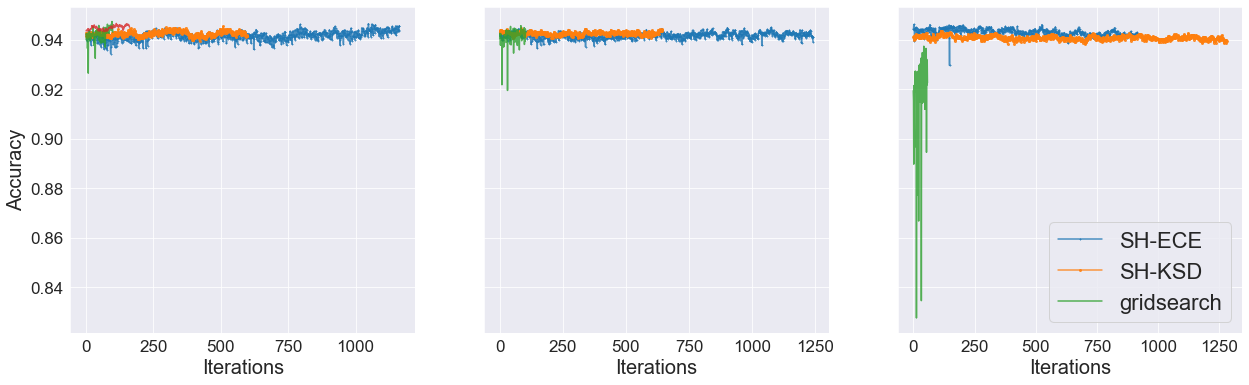

In [91]:
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(1,3, figsize=(21, 6), sharey=True)


ax[0].plot(list_acc_sgld_SH_ECE[burnin_sgld_ECE:], alpha=.8, label="SH-ECE", marker="+", markersize=2)
ax[0].plot(list_acc_sgld_SH_KSD[burnin_sgld_KSD:], alpha=.8, label="SH-KSD", marker="o", markersize=2)
ax[0].plot(list_acc_sgld_default[burnin_sgld_default:], alpha=.8, label="gridsearch")
ax[0].plot(list_acc_sgld_adam[burnin_sgld_adam:], alpha=.8, label="adam")

ax[1].plot(list_acc_svrg_SH_ECE[burnin_svrg_SH_ECE:], alpha=.8, label="SH-ECE", marker="+", markersize=2)
ax[1].plot(list_acc_svrg_SH_KSD[burnin_svrg_SH_KSD:], alpha=.8, label="SH-KSD", marker="o", markersize=2)
ax[1].plot(list_acc_svrg_default[burnin_svrg_default:], alpha=.8, label="gridsearch")

ax[2].plot(list_acc_sghmc_SH_ECE[burnin_sghmc_SH_ECE:], alpha=.8, label="SH-ECE", marker="+", markersize=2)
ax[2].plot(list_acc_sghmc_SH_KSD[burnin_sghmc_SH_KSD:], alpha=.8, label="SH-KSD", marker="o", markersize=2)
ax[2].plot(list_acc_sghmc_default[burnin_sghmc_default:], alpha=.8, label="gridsearch")

ax[0].set_ylabel("Accuracy", size=20)
ax[0].set_xlabel("Iterations", size=20)
ax[1].set_xlabel("Iterations", size=20)
ax[2].set_xlabel("Iterations", size=20)
plt.legend(fontsize=22)
# plt.savefig("images/NN_accuracy_plots.png")